In [70]:
import hdmpy
import patsy
import warnings
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator

warnings.simplefilter('ignore')

In [229]:
# !pip install multiprocess
# !pip install pyreadr
# !git clone https://github.com/maxhuppertz/hdmpy.git

# Assignment-1

## 1-a

In [2]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
data = pd.read_csv(file)

In [3]:
data

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
0,9.615385,2.263364,1,0,0,0,1,0,0,0,0,1,7.0,0.49,0.343,0.2401,3600.0,11,8370.0,18
1,48.076923,3.872802,0,0,0,0,1,0,0,0,0,1,31.0,9.61,29.791,92.3521,3050.0,10,5070.0,9
2,11.057692,2.403126,0,0,1,0,0,0,0,0,0,1,18.0,3.24,5.832,10.4976,6260.0,19,770.0,4
3,13.942308,2.634928,1,0,0,0,0,1,0,0,0,1,25.0,6.25,15.625,39.0625,420.0,1,6990.0,12
4,28.846154,3.361977,1,0,0,0,1,0,0,0,0,1,22.0,4.84,10.648,23.4256,2015.0,6,9470.0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,14.769231,2.692546,0,0,0,0,1,0,0,0,1,0,9.0,0.81,0.729,0.6561,4700.0,16,4970.0,9
5146,23.076923,3.138833,1,0,0,1,0,0,0,0,1,0,12.0,1.44,1.728,2.0736,4110.0,13,8680.0,20
5147,38.461538,3.649659,0,0,0,0,0,1,0,0,1,0,11.0,1.21,1.331,1.4641,1550.0,4,3680.0,6
5148,32.967033,3.495508,0,0,1,0,0,0,0,0,1,0,10.0,1.00,1.000,1.0000,2920.0,9,6570.0,11


### Unconditional wage gap due to college education

In [4]:
data[data["clg"] == 1]["lwage"].mean() - data[data["clg"] == 0]["lwage"].mean()

0.23871669071457058

In [5]:
cl = smf.ols("np.log(wage) ~ clg", data)
cl_results = cl.fit(cov_type="HC1")
cl_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     217.4
Date:                Mon, 30 Jan 2023   Prob (F-statistic):           3.11e-48
Time:                        19:24:47   Log-Likelihood:                -4315.9
No. Observations:                5150   AIC:                             8636.
Df Residuals:                    5148   BIC:                             8649.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8950      0.010    298.327      0.000       2.876       2.914
clg            0.2387      0.016     14.746      0.000       0.207       0.270
==============================================================================
Omnibus:                      320.661   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              617.806
Skew:                           0.446   Prob(JB):                    7.00e-135
Kurtosis:                       4.443   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

#### The unconditional wage gap (in log-wage units) between those with college education and without is 0.2387

### Basic Control

In [6]:
### Controls
## sex, mw, so, we, exp1, exp2, exp3, exp4, and one hot encodings of occ2 and ind2

In [7]:
basic_control = smf.ols("np.log(wage) ~ clg + (sex+mw+so+we+exp1+exp2+exp3+exp4+C(occ2)+C(ind2))",
              data)
basic_control_results = basic_control.fit(cov_type="HC1")
basic_control_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     40.30
Date:                Mon, 30 Jan 2023   Prob (F-statistic):               0.00
Time:                        19:24:58   Log-Likelihood:                -3631.3
No. Observations:                5150   AIC:                             7365.
Df Residuals:                    5099   BIC:                             7699.
Df Model:                          50                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.4508      0.100     34.447      0.000       3.254       3.647
C(occ2)[T.2]     -0.0616      0.037     -1.671      0.095      -0.134       0.011
C(occ2)[T.3]     -0.0143      0.040     -0.357      0.721      -0.093       0.064
C(occ2)[T.4]     -0.0849      0.049     -1.741      0.082      -0.181       0.011
C(occ2)[T.5]     -0.0803      0.061     -1.318      0.187      -0.200       0.039
C(occ2)[T.6]     -0.3605      0.046     -7.860      0.000      -0.450      -0.271
C(occ2)[T.7]      0.1203      0.075      1.604      0.109      -0.027       0.267
C(occ2)[T.8]     -0.3444      0.043     -8.074      0.000      -0.428      -0.261
C(occ2)[T.9]     -0.2510      0.051     -4.909      0.000      -0.351      -0.151
C(occ2)[T.10]     0.0279      0.046      0.606      0.544      -0.062       0.118
C(occ2)[T.11]    -0.5689      0.050    -11.392      0.000      -0.667      -0.471
C(occ2)[T.12]    -0.3894      0.062     -6.309      0.000      -0.510      -0.268
C(occ2)[T.13]    -0.4295      0.044     -9.664      0.000      -0.517      -0.342
C(occ2)[T.14]    -0.6299      0.045    -13.884      0.000      -0.719      -0.541
C(occ2)[T.15]    -0.5572      0.051    -10.890      0.000      -0.657      -0.457
C(occ2)[T.16]    -0.2792      0.037     -7.454      0.000      -0.353      -0.206
C(occ2)[T.17]    -0.4876      0.028    -17.511      0.000      -0.542      -0.433
C(occ2)[T.18]    -0.4185      0.187     -2.243      0.025      -0.784      -0.053
C(occ2)[T.19]    -0.3635      0.048     -7.641      0.000      -0.457      -0.270
C(occ2)[T.20]    -0.3208      0.043     -7.522      0.000      -0.404      -0.237
C(occ2)[T.21]    -0.3980      0.038    -10.458      0.000      -0.473      -0.323
C(occ2)[T.22]    -0.5406      0.041    -13.128      0.000      -0.621      -0.460
C(ind2)[T.3]     -0.1259      0.115     -1.098      0.272      -0.351       0.099
C(ind2)[T.4]     -0.2528      0.094     -2.686      0.007      -0.437      -0.068
C(ind2)[T.5]     -0.2466      0.097     -2.534      0.011      -0.437      -0.056
C(ind2)[T.6]     -0.2570      0.095     -2.713      0.007      -0.443      -0.071
C(ind2)[T.7]     -0.1724      0.115     -1.499      0.134      -0.398       0.053
C(ind2)[T.8]     -0.2064      0.111     -1.862      0.063      -0.424       0.011
C(ind2)[T.9]     -0.4033      0.095     -4.264      0.000      -0.589      -0.218
C(ind2)[T.10]    -0.1821      0.100     -1.825      0.068      -0.378       0.013
C(ind2)[T.11]    -0.1250      0.102     -1.222      0.222      -0.325       0.076
C(ind2)[T.12]    -0.0517      0.096     -0.537      0.591      -0.240       0.137
C(ind2)[T.13]    -0.1712      0.103     -1.665      0.096      -0.373       0.030
C(ind2)[T.14]    -0.1475      0.095     -1.554      0.120      -0.334       0.039
C(ind2)[T.15]    -0.3438      0.145     -2.369   

In [8]:
APE, std_err = basic_control_results.params["clg"], basic_control_results.HC1_se["clg"]
ci = [APE-1.96*std_err, APE+1.96*std_err]

In [9]:
print(f'The Average Predictive Effect is {APE}')
print(f'The 95% Confidence Interval for APE is {ci}')

The Average Predictive Effect is 0.13285534860067444
The 95% Confidence Interval for APE is [0.10068811250358381, 0.16502258469776507]


### Flexible controls (pairwise interactions) - OLS

In [10]:
flex = smf.ols("np.log(wage) ~ (clg+sex+mw+so+we+exp1+exp2+exp3+exp4+C(occ2)+C(ind2))**2",
              data)
flex_results = flex.fit(cov_type="HC1")
flex_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     3453.
Date:                Mon, 30 Jan 2023   Prob (F-statistic):               0.00
Time:                        19:25:36   Log-Likelihood:                -3097.1
No. Observations:                5150   AIC:                             7590.
Df Residuals:                    4452   BIC:                         1.216e+04
Df Model:                         697                                         
Covariance Type:                  HC1                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.3675      0.753      3.143      0.002       0.891       3.844
C(occ2)[T.2]                   -0.3844      0.456     -0.843      0.399      -1.279       0.510
C(occ2)[T.3]                    0.1908      0.184      1.036      0.300      -0.170       0.552
C(occ2)[T.4]                   -0.1286      0.619     -0.208      0.836      -1.342       1.085
C(occ2)[T.5]                   -0.4786      0.515     -0.929      0.353      -1.489       0.532
C(occ2)[T.6]                   -0.1590      0.175     -0.909      0.364      -0.502       0.184
C(occ2)[T.7]                   -0.7527      0.449     -1.676      0.094      -1.633       0.128
C(occ2)[T.8]                   -0.4308      0.177     -2.439      0.015      -0.777      -0.085
C(occ2)[T.9]                   -0.9149      0.486     -1.884      0.060      -1.867       0.037
C(occ2)[T.10]                  -0.9742      0.533     -1.827      0.068      -2.019       0.071
C(occ2)[T.11]                  -0.6663      0.239     -2.787      0.005      -1.135      -0.198
C(occ2)[T.12]                  -0.1707      0.376     -0.454      0.650      -0.907       0.566
C(occ2)[T.13]                  -0.6721      0.299     -2.250      0.024      -1.258      -0.087
C(occ2)[T.14]                   0.1398      0.330      0.423      0.672      -0.507       0.787
C(occ2)[T.15]                   0.0393      0.260      0.151      0.880      -0.470       0.548
C(occ2)[T.16]                  -0.1651      0.457     -0.361      0.718      -1.062       0.731
C(occ2)[T.17]                  -0.6268      0.481     -1.304      0.192      -1.569       0.315
C(occ2)[T.18]               -9.757e-05      0.030     -0.003      0.997      -0.058       0.058
C(occ2)[T.19]                  -0.2002      0.539     -0.372      0.710      -1.256       0.855
C(occ2)[T.20]                   0.0702      0.573      0.122      0.903      -1.054       1.194
C(occ2)[T.21]                  -1.0733      0.634     -1.693      0.090      -2.316       0.169
C(occ2)[T.22]                  -0.8769      0.570     -1.538      0.124      -1.995       0.241
C(ind2)[T.3]                   -0.3716      0.909     -0.409      0.683      -2.154       1.411
C(ind2)[T.4]                    1.2115      0.756      1.602      0.109      -0.270       2.693
C(ind2)[T.5]                    0.6525      0.765      0.853      0.394      -0.846       2.151
C(ind2)[T.6]                    0.5580      0.756      0.738      0.460      -0.924       2.039
C(ind2)[T.7]                    1.0308      0.909      1.134      0.257      -0.751       2.813
C(ind2)[T.8]                    0.6899      0.769      0.897      0.370      -0.817       2.197
C(ind2)[T.9]                    0.6552      0.762      0.860      0.390      -0.838       2.148
C(ind2)[T.1

In [11]:
print(f'Average Predictive Effect from OLS is {flex_results.params[flex.exog_names.index("clg")]}')
print(f'Std Error of APE is {flex_results.HC1_se[flex.exog_names.index("clg")]}')

Average Predictive Effect from OLS is 0.6402715335143685
Std Error of APE is 0.19981935328215403


### double LASSO

In [4]:
y = np.log(data['wage']).values
Z = data.drop(['wage', 'lwage'], axis=1)
Z.columns

Index(['sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so', 'we', 'ne', 'exp1',
       'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2'],
      dtype='object')

In [204]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
lasso_model = lambda: make_pipeline(StandardScaler(), LassoCV(cv=cv))

def double_lasso(y, D, W):
    yres = y - lasso_model().fit(W, y).predict(W)
    Dres = D - lasso_model().fit(W, D).predict(W)
    hat = np.mean(yres * Dres) / np.mean(Dres**2)
    epsilon = yres - hat * Dres
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2
    return hat, np.sqrt(V / y.shape[0])

Zcontrols = patsy.dmatrix('0 + (clg+sex+mw+so+we+exp1+exp2+exp3+exp4+C(occ2)+C(ind2))**2',
                           Z, return_type='dataframe')

Zcontrols = Zcontrols - Zcontrols.mean(axis=0)
W = Zcontrols.drop('clg', axis=1)
D = Zcontrols['clg']

hat, stderr = double_lasso(y, D, W)

In [106]:
print(f'The mean predictive effect from double LASSO is {hat}')
print(f'The std error from double LASSO is {stderr}')


The mean predictive effect from double LASSO is 0.5287349828233784
The std error from double LASSO is 0.16568440079351474


## 1-b (Heterogeneity)

In [16]:
## [1, sex, mw, so, we, exp1, exp2, exp3, exp4]

### Class approach to dataset creation

In [5]:
Zcontrols = patsy.dmatrix('0 + (sex+mw+so+we+exp1+exp2+exp3+exp4+C(occ2)+C(ind2))**2',
                           Z, return_type='dataframe')

Zcontrols = Zcontrols - Zcontrols.mean(axis=0)

In [6]:
Zhet = patsy.dmatrix('0 + (sex+mw+so+we+exp1+exp2+exp3+exp4)',
                      Z, return_type='dataframe')
Zhet = Zhet - Zhet.mean(axis=0)

In [7]:
Zhet['clg'] = Z['clg']
Zinteractions = patsy.dmatrix('0 + clg + clg * (sex+mw+so+we+exp1+exp2+exp3+exp4)',
                               Zhet, return_type='dataframe')

In [21]:
X = pd.concat([Zinteractions, Zcontrols], axis=1)
X = X.loc[:,~X.columns.duplicated()] ### remove duplicate columns

In [22]:
interaction_cols = [c for c in X.columns if c.startswith('clg')]
interaction_cols

['clg',
 'clg:sex',
 'clg:mw',
 'clg:so',
 'clg:we',
 'clg:exp1',
 'clg:exp2',
 'clg:exp3',
 'clg:exp4']

### Linear Regression

In [23]:
lin_reg_sk = LinearRegression().fit(X, y.reshape(-1,1))

In [24]:
results = pd.DataFrame(zip(X.columns, lin_reg_sk.coef_[0]), columns=["features", "coeffs"])
results[results["features"].str.contains("clg")]

,features,coeffs
0,clg,0.117377
9,clg:sex,0.017932
10,clg:mw,0.018625
11,clg:so,-0.013975
12,clg:we,-0.063808
13,clg:exp1,0.065278
14,clg:exp2,-0.636869
15,clg:exp3,0.235067
16,clg:exp4,-0.028674


### LassoCV

In [117]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
lasso_cv = make_pipeline(StandardScaler(), LassoCV(cv=cv))

In [118]:
lasso_cv.fit(X, y.reshape(-1,1))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv',
                 LassoCV(cv=KFold(n_splits=5, random_state=123, shuffle=True)))])

In [171]:
results = pd.DataFrame(zip(X.columns, lasso_cv[-1].coef_), columns=["features", "scaled_params"])
results = results[results["features"].str.contains("clg")]

In [172]:
### indices of scaling factors from Standard Scaler()
ind = [i for i,j in enumerate(lasso_cv.feature_names_in_) if 'clg' in j] 

In [173]:
results["scaling_factor"] = lasso_cv[0].scale_[ind]
results['true_coeffs'] = results['scaled_params']/results['scaling_factor']

In [174]:
results

,features,scaled_params,scaling_factor,true_coeffs
0,clg,0.060344,0.465570,0.129613
9,clg:sex,-0.000000,0.282361,-0.000000
10,clg:mw,0.000000,0.237941,0.000000
11,clg:so,0.000000,0.255543,0.000000
12,clg:we,-0.004723,0.232797,-0.020290
13,clg:exp1,0.000000,5.818262,0.000000
14,clg:exp2,0.000000,1.997323,0.000000
15,clg:exp3,-0.000000,6.817383,-0.000000
16,clg:exp4,-0.000000,23.964341,-0.000000


#### All coefficients except clg and clg:we are 0; reflecting the large sparsity bias inherent to LASSO, especially in cases where $p/n$ ratio is not very low, it will deliberately penalize many coefficients to be 0, even when they might be important in a predictive sense.

### RidgeCV

In [175]:
ridge_cv = make_pipeline(StandardScaler(), RidgeCV(cv=cv))

In [176]:
ridge_cv.fit(X, y.reshape(-1,1))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                         cv=KFold(n_splits=5, random_state=123, shuffle=True)))])

In [182]:
results = pd.DataFrame(zip(X.columns, ridge_cv[-1].coef_[0]), columns=["features", "scaled_params"])
results = results[results["features"].str.contains("clg")]

In [183]:
### indices of scaling factors from Standard Scaler()
ind = [i for i,j in enumerate(ridge_cv.feature_names_in_) if 'clg' in j] 
results["scaling_factor"] = lasso_cv[0].scale_[ind]
results['true_coeffs'] = results['scaled_params']/results['scaling_factor']

In [184]:
results

,features,scaled_params,scaling_factor,true_coeffs
0,clg,0.058906,0.465570,0.126524
9,clg:sex,0.004077,0.282361,0.014440
10,clg:mw,0.009520,0.237941,0.040009
11,clg:so,0.000473,0.255543,0.001851
12,clg:we,-0.013079,0.232797,-0.056180
13,clg:exp1,0.044409,5.818262,0.007633
14,clg:exp2,-0.039310,1.997323,-0.019681
15,clg:exp3,-0.011204,6.817383,-0.001644
16,clg:exp4,0.016732,23.964341,0.000698


### ElasticNetCV

In [49]:
elastic_cv = make_pipeline(StandardScaler(), ElasticNetCV(cv=cv))

In [50]:
elastic_cv.fit(X, y.reshape(-1,1))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('elasticnetcv',
                 ElasticNetCV(cv=KFold(n_splits=5, random_state=123, shuffle=True)))])

In [185]:
results = pd.DataFrame(zip(X.columns, elastic_cv[-1].coef_[:,]), columns=["features", "scaled_params"])
results = results[results["features"].str.contains("clg")]

In [186]:
### indices of scaling factors from Standard Scaler()
ind = [i for i,j in enumerate(elastic_cv.feature_names_in_) if 'clg' in j] 
results["scaling_factor"] = lasso_cv[0].scale_[ind]
results['true_coeffs'] = results['scaled_params']/results['scaling_factor']

In [187]:
results

,features,scaled_params,scaling_factor,true_coeffs
0,clg,0.059999,0.465570,0.128872
9,clg:sex,-0.000000,0.282361,-0.000000
10,clg:mw,0.000000,0.237941,0.000000
11,clg:so,0.000000,0.255543,0.000000
12,clg:we,-0.004654,0.232797,-0.019990
13,clg:exp1,0.000145,5.818262,0.000025
14,clg:exp2,0.000000,1.997323,0.000000
15,clg:exp3,-0.000000,6.817383,-0.000000
16,clg:exp4,-0.000000,23.964341,-0.000000


### RLasso

In [67]:
class RLasso(BaseEstimator):
    
    def __init__(self, *, post=False):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    @property
    def coef_(self):
        return np.array(self.rlasso_.est['beta']).flatten()

    def predict(self, X):
        return X @ self.coef_ + np.array(self.rlasso_.est['intercept'])

In [96]:
rlasso = RLasso().fit(X, y.reshape(-1,1))

In [98]:
results = pd.DataFrame(zip(X.columns, rlasso.coef_[:,]), columns=["features", "coeffs"])
results[results["features"].str.contains("clg")]

,features,coeffs
0,clg,0.127334
9,clg:sex,0.000000
10,clg:mw,0.000000
11,clg:so,0.000000
12,clg:we,0.000000
13,clg:exp1,0.000000
14,clg:exp2,0.000000
15,clg:exp3,0.000000
16,clg:exp4,0.000000


## 1-c

In [101]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
lasso_model = lambda: make_pipeline(StandardScaler(), LassoCV(cv=cv))

alpha = {}
res_y, res_D, epsilon = {}, {}, {}
for c in interaction_cols:
    print(f"Double Lasso for target variable {c}")
    D = X[c].values
    W = X.drop([c], axis=1)
    res_y[c] = y - lasso_model().fit(W, y).predict(W)
    res_D[c] = D - lasso_model().fit(W, D).predict(W)
    final = LinearRegression(fit_intercept=False).fit(res_D[c].reshape(-1, 1), res_y[c])
    epsilon[c] = res_y[c] - final.predict(res_D[c].reshape(-1, 1))
    alpha[c] = [final.coef_[0]]

Double Lasso for target variable clg
Double Lasso for target variable clg:sex
Double Lasso for target variable clg:mw
Double Lasso for target variable clg:so
Double Lasso for target variable clg:we
Double Lasso for target variable clg:exp1
Double Lasso for target variable clg:exp2
Double Lasso for target variable clg:exp3
Double Lasso for target variable clg:exp4


In [106]:
pd.DataFrame.from_dict(alpha, orient='index', columns=["coeffs"])

,coeffs
clg,0.136170
clg:sex,0.004204
clg:mw,0.042637
clg:so,0.004920
clg:we,-0.074034
clg:exp1,0.012827
clg:exp2,0.053326
clg:exp3,0.001427
clg:exp4,-0.003301


#### Unlike LASSO-CV earlier in 1b, the results from RLasso do NOT set most of the coefficients as 0. This is mainly due to the double lasso step overcoming the sparsity bias, by penalizing the coefficients of all other nuisance covariates (pushing them to essentially 0).

## 1-d

### Covariance matrix of coefficients

In [107]:
V = np.zeros((len(interaction_cols), len(interaction_cols)))
for it, c in enumerate(interaction_cols):
    Jc = np.mean(res_D[c]**2)
    for itp, cp in enumerate(interaction_cols):
        Jcp = np.mean(res_D[cp]**2)
        Sigma = np.mean(res_D[c] * epsilon[c] * epsilon[cp] * res_D[cp])
        V[it, itp] = Sigma / (Jc * Jcp)

### DIagonal of Covariance matrix

In [114]:
np.diag(V)

array([ 1.33371298,  5.02544417, 11.66389889,  9.57363042, 10.2949148 ,
        0.65317274, 60.49510859, 16.3078642 ,  0.18665819])

### Std Error of coefficients

In [111]:
n = X.shape[0]
for it, c in enumerate(interaction_cols):
    alpha[c] += [np.sqrt(V[it, it] / n)]
df = pd.DataFrame.from_dict(alpha, orient='index', columns=['point', 'stderr'])
df

,point,stderr
clg,0.136170,0.016093
clg:sex,0.004204,0.031238
clg:mw,0.042637,0.047590
clg:so,0.004920,0.043116
clg:we,-0.074034,0.044710
clg:exp1,0.012827,0.011262
clg:exp2,0.053326,0.108382
clg:exp3,0.001427,0.056272
clg:exp4,-0.003301,0.006020


In [115]:
Drootinv = np.diagflat(1/np.sqrt(np.diag(V)))
scaledCov = Drootinv @ V @ Drootinv

np.random.seed(123)
U = np.random.multivariate_normal(np.zeros(scaledCov.shape[0]), scaledCov, size=10000)
z = np.max(np.abs(U), axis=1)
c = np.percentile(z, 95)
c

2.736351291406547

### This value of $c = 2.736$ is much higher than the typical value of $1.96$ we would use to  construct a simple 95% confidence interval for one coefficient.

# Assignment-2

## 2-a

In [189]:

sample_sizes = [50, 150, 250, 350, 450, 550, 650, 750]
d = 10 
p = 0.2  
delta = 1 
base =0.3

,coverage,ATE,std err
50,0.828,NaN,NaN
150,0.916,0.995814,0.374358
250,0.915,0.996698,0.294074
350,0.955,1.009548,0.250306
450,0.951,0.996409,0.219036
550,0.950,0.992272,0.200558
650,0.940,1.002834,0.183260
750,0.941,1.002227,0.170729


,coverage,ATE,std err
50,0.911,0.981207,0.477791
150,0.935,0.996968,0.286894
250,0.949,1.008125,0.221656
350,0.940,1.010976,0.188524
450,0.953,1.001582,0.166556
550,0.939,1.001565,0.150562
650,0.948,0.997623,0.138516
750,0.958,0.999640,0.128833


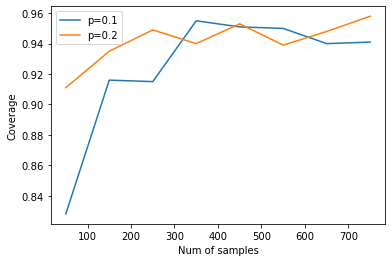

In [220]:
from collections import defaultdict
# np.random.seed(42)

# A simple experimental data generating process
def gen_data(n, d, p, delta, base):
    D = np.random.binomial(1, p, size=(n,))
    X = np.random.normal(0, 1, size=(n, d))
    y0 = base - X[:, 0] + np.random.normal(0, 1, size=(n,))
    y1 = delta + base - X[:, 0] + np.random.normal(0, 1, size=(n,))
    y = y1 * D + y0 * (1 - D)
    return y, D, X

def twomeans(y, D):
    hat0 = np.mean(y[D==0]) # mean of outcome of un-treated
    hat1 = np.mean(y[D==1]) # mean of outcome of treated
    V0 = np.var(y[D==0]) / np.mean(1 - D) # asymptotic variance of the mean of outcome of untreated
    V1 = np.var(y[D==1]) / np.mean(D) # asymptotic variance of the mean of outcome of treated
    return hat0, hat1, V0, V1

def get_coverage(sample_sizes, d, p, delta, base, trials):
    params = defaultdict(list)
    coverage = {}
    for sample_size in sample_sizes:
        cov, hats, stderrs = [], [], []
        for _ in range(trials):
            y, D, X = gen_data(sample_size, d, p, delta, base)
            hat0, hat1, V0, V1 = twomeans(y, D)
            hat = hat1 - hat0
            hats.append(hat)
            stderr = np.sqrt((V0 + V1) / sample_size)
            stderrs.append(stderr)
            ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
            cov += [(ci[0] <= delta) & (delta <= ci[1])] 
        params[sample_size].append(np.mean(cov))
        params[sample_size].append(np.mean(hats))
        params[sample_size].append(np.mean(stderrs))
        coverage[sample_size] = np.mean(cov)
    return coverage, params


for prob in [0.1, 0.2]:
    coverage, params = get_coverage(p=prob, sample_sizes=sample_sizes, d=d, delta=delta, base=base, trials=1000)
    lists = sorted(coverage.items()) 
    x, y = zip(*lists) 
    plt.plot(x, y, label = f'p={prob}')
    plt.xlabel("Num of samples")
    plt.ylabel("Coverage")
    plt.legend()
    display(pd.DataFrame.from_dict(params, orient='index', columns=["coverage", "ATE", "std err"]))
plt.show()

#### For 10 covariates, as we have in the problem here, it seems that the parameter reaches ~95% coverage with about 350 or so samples, suggesting that the $p/n$ ratio is approx 0.03, i.e., $p/n < 1$  For probability of treatment = 0.1, this number is higher , approx 550, since more samples are needed to have a significant number so treated population.

## 2-b

In [192]:
def partialling_out(y, D, W):
    yres = y - LinearRegression().fit(W, y).predict(W) # residualize outcome with OLS
    Dres = D - LinearRegression().fit(W, D).predict(W) # residualize treatment with OLS
    hat = np.mean(yres * Dres) / np.mean(Dres**2) # calculate final residual ~ residual ols estimate
    epsilon = yres - hat * Dres # calculate residual of final regression; epsilon in the BLP decomposition
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2 # calculate variance of effect
    return hat, np.sqrt(V / y.shape[0])

,coverage,ATE,std err
50,0.768,0.978123,5.364580e+13
150,0.858,0.996492,1.924897e-01
250,0.906,0.994504,1.533702e-01
350,0.926,0.997823,1.307397e-01
450,0.936,1.007772,1.158274e-01
550,0.931,1.002297,1.055031e-01
650,0.947,0.996324,9.712274e-02
750,0.941,0.998222,9.035601e-02


,coverage,ATE,std err
50,0.881,0.994308,0.343053
150,0.921,1.000445,0.202163
250,0.927,0.998475,0.156951
350,0.941,1.004823,0.132719
450,0.946,0.996906,0.117504
550,0.951,0.998397,0.106499
650,0.946,0.998872,0.097821
750,0.951,1.000948,0.091117


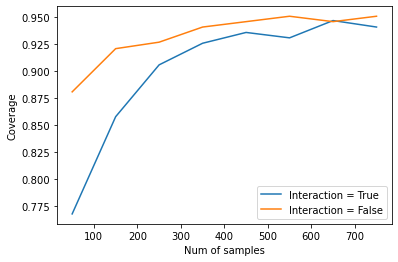

In [224]:
np.random.seed(42)
p = 0.2
def get_coverage_OLS(sample_sizes, d, p, delta, base, trials, interaction):
    params = defaultdict(list)
    coverage = {}
    for sample_size in sample_sizes:
        cov, hats, stderrs = [], [], [],
        for _ in range(trials):
            y, D, X = gen_data(sample_size, d, p, delta, base)
            X = X-X.mean(axis=0)
            if not interaction: 
                hat, stderr = partialling_out(y, D, X)
            else:
                hat, stderr = partialling_out(y, D, np.hstack([D.reshape(-1,1)*X, X]))
            hats.append(hat)
            stderrs.append(stderr)
            ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
            cov += [(ci[0] <= delta) & (delta <= ci[1])] 
        coverage[sample_size] = np.mean(cov)
        params[sample_size].append(np.mean(cov))
        params[sample_size].append(np.mean(hats))
        params[sample_size].append(np.mean(stderrs))
    return coverage, params 


interactions = [True, False]

for interaction in interactions:

    coverage, params = get_coverage_OLS(p=p, sample_sizes=sample_sizes, d=d, delta=delta, base=base, trials=1000, interaction=interaction)
    lists = sorted(coverage.items()) 
    x, y = zip(*lists) 
    plt.plot(x, y, label = f'Interaction = {interaction}')
    plt.xlabel("Num of samples")
    plt.ylabel("Coverage")
    plt.legend()
    display(pd.DataFrame.from_dict(params, orient='index', columns=["coverage", "ATE", "std err"]))

## 2-c

In [226]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
lasso_model = lambda: make_pipeline(StandardScaler(), LassoCV(cv=cv))

def double_lasso(y, D, W):
    yres = y - lasso_model().fit(W, y).predict(W)
    Dres = D - lasso_model().fit(W, D).predict(W)
    hat = np.mean(yres * Dres) / np.mean(Dres**2)
    epsilon = yres - hat * Dres
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2
    return hat, np.sqrt(V / y.shape[0])
    

,coverage,ATE,std err
50,0.78,11.910990,6.706996
150,0.92,0.942472,0.201204
250,0.93,0.994685,0.153173
350,0.94,0.990171,0.129966
450,0.97,0.997421,0.119025
550,0.96,1.006611,0.104922
650,0.97,1.001091,0.097177
750,0.95,0.983381,0.090407


,coverage,ATE,std err
50,0.92,0.992972,0.325650
150,0.90,0.959281,0.201796
250,0.94,1.010327,0.156860
350,0.98,0.988137,0.132333
450,0.93,1.000852,0.116465
550,0.95,1.004201,0.106661
650,0.96,0.996117,0.097116
750,0.92,0.982199,0.091460


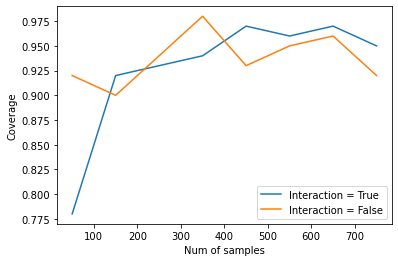

In [228]:
np.random.seed(42)
p = 0.2
def get_coverage_doubleLASSO(sample_sizes, d, p, delta, base, trials, interaction):
    params = defaultdict(list)
    coverage = {}
    for sample_size in sample_sizes:
        cov, hats, stderrs = [], [], [],
        for _ in range(trials):
            y, D, X = gen_data(sample_size, d, p, delta, base)
            X = X-X.mean(axis=0)
            if not interaction: 
                hat, stderr = double_lasso(y, D, X)
            else:
                hat, stderr = double_lasso(y, D, np.hstack([D.reshape(-1,1)*X, X]))
            hats.append(hat)
            stderrs.append(stderr)
            ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
            cov += [(ci[0] <= delta) & (delta <= ci[1])] 
        coverage[sample_size] = np.mean(cov)
        params[sample_size].append(np.mean(cov))
        params[sample_size].append(np.mean(hats))
        params[sample_size].append(np.mean(stderrs))
    return coverage, params


interactions = [True, False]

for interaction in interactions:
    coverage, params = get_coverage_doubleLASSO(p=p, sample_sizes=sample_sizes, d=d, delta=delta, base=base, trials=100, interaction=interaction)
    lists = sorted(coverage.items()) 
    x, y = zip(*lists) 
    plt.plot(x, y, label = f'Interaction = {interaction}')
    plt.xlabel("Num of samples")
    plt.ylabel("Coverage")
    plt.legend()
    display(pd.DataFrame.from_dict(params, orient='index', columns=["coverage", "ATE", "std err"]))

#### Including interaction terms gives rise to many more parameters such that $p/n$ is not small anymore. LASSO does well in these cases, and even with 250-300 samples (for w/ interaction) achieves coverage at the 95% level - unlike Linear Regression whcih takes close to 650 samples to achieve the same coverage.


## Note: Since the double Lasso was an expensive calculation, I only tried a run with a 100 trials, unlike all other cases where I tried 1000 trials.

## BONUS - Using RLasso

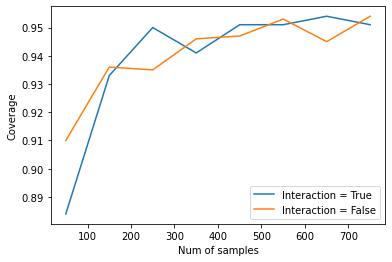

In [202]:
def double_Rlasso(y, D, W):
    yres = y - RLasso().fit(W, y).predict(W)   ### Replace LASSO-CV with RLasso
    Dres = D - RLasso().fit(W, D).predict(W)   ### Replace LASSO-CV with RLasso
    hat = np.mean(yres * Dres) / np.mean(Dres**2)
    epsilon = yres - hat * Dres
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2
    return hat, np.sqrt(V / y.shape[0])
    


np.random.seed(42)
p = 0.2
def get_coverage_RLASSO(sample_sizes, d, p, delta, base, trials, interaction):
    coverage = {}
    for sample_size in sample_sizes:
        cov = []
        for _ in range(trials):
            y, D, X = gen_data(sample_size, d, p, delta, base)
            X = X-X.mean(axis=0)
            if not interaction: 
                hat, stderr = double_Rlasso(y, D, X)
            else:
                hat, stderr = double_Rlasso(y, D, np.hstack([D.reshape(-1,1)*X, X]))
            ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
            cov += [(ci[0] <= delta) & (delta <= ci[1])] 
        coverage[sample_size] = np.mean(cov)
    return coverage


interactions = [True, False]

for interaction in interactions:

    coverage = get_coverage_RLASSO(p=p, sample_sizes=sample_sizes, d=d, delta=delta, base=base, trials=1000, interaction=interaction)
    lists = sorted(coverage.items()) 
    x, y = zip(*lists) 
    plt.plot(x, y, label = f'Interaction = {interaction}')
    plt.xlabel("Num of samples")
    plt.ylabel("Coverage")
    plt.legend()

# Assignment 3

### Please see attached image of hand-written solution